# De student is in staat om:

1.12 een dataclass maken.

In [43]:
from dataclasses import dataclass

@dataclass
class Person:
    name: str
    age: int
    weight: float

    def hoe_heet_je(self):
        print(f"Mijn naam is {self.name}")
    
    def hoe_oud_ben_je(self):
        print(f"Ik ben {self.age} jaar oud")

    def hoe_zwaar_ben_je(self):
        print(f"ik ben {self.weight} kg zwaar")

In [44]:
tyco = Person("Tyco", 30, 92.5)

In [47]:
tyco.hoe_heet_je()
tyco.hoe_oud_ben_je()
tyco.hoe_zwaar_ben_je()   

Mijn naam is Tyco
Ik ben 30 jaar oud
ik ben 92.5 kg zwaar


1.13 Een configureerbaar dense neural network te maken met pytorch.

In [81]:
import torch
import torch.nn as nn

# in dit geval gebruik ik geen @dataclass omdat ik dan niet de flatten en linear_relu_stack kan initialiseren
class DenseNeuralNetwork(nn.Module):
    def __init__(self, num_classes, units1, units2, input_size):
        super().__init__() # moet erbij zodat alles van de nn module wordt overgenomen
        self.num_classes = num_classes
        self.units1 = units1         
        self.units2 = units2
        self.input_size = input_size
        self.flatten = nn.Flatten()

        # ik kies hier voor een simpel model met 2 hidden layers
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(self.input_size, self.units1),
            nn.ReLU(),
            nn.Linear(self.units1, self.units2),
            nn.ReLU(),
            nn.Linear(self.units2, self.num_classes)
        )
    
    # forward maken we hier zodat we de volgorde van de bewerkingen kunnen bepalen, eerst flattenen zodat we de input in 1D krijgen en dus kunnen doorgeven aan de linear layers
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [25]:
model = DenseNeuralNetwork(num_classes=10, units1=512, units2=256, input_size=28*28)
model

DenseNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

1.14 tensorboard gebruiken om zijn model te monitoren

In [2]:
import torch
from mltrainer import imagemodels, Trainer, TrainerSettings, ReportTypes, metrics
loss_fn = torch.nn.CrossEntropyLoss()

# set trainingsettings
settings = TrainerSettings(
    epochs=3,
    metrics= [metrics.Accuracy()],
    logdir="modellogs",
    train_steps= 50,
    valid_steps= 50,
    reporttypes=[ReportTypes.TENSORBOARD],
)

In [95]:
# impport dataset and make data streamers
from mads_datasets import DatasetFactoryProvider, DatasetType
from mltrainer.preprocessors import BasePreprocessor
batchsize = 64
fashionfactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION)
preprocessor = BasePreprocessor()
streamers = fashionfactory.create_datastreamer(batchsize=batchsize, preprocessor=preprocessor)
train = streamers["train"]
valid = streamers["valid"]
trainstreamer = train.stream()
validstreamer = valid.stream()

2025-10-04 17:54:50.064 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at C:\Users\tycoh\.cache\mads_datasets\fashionmnist
2025-10-04 17:54:50.071 | INFO     | mads_datasets.base:download_data:124 - File already exists at C:\Users\tycoh\.cache\mads_datasets\fashionmnist\fashionmnist.pt


In [7]:
# make model trainer
import torch.optim as optim

trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=loss_fn,
    optimizer=optim.Adam,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=optim.lr_scheduler.ReduceLROnPlateau
)
trainer.loop()

2025-10-04 10:13:09.311 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs\20251004-101309
2025-10-04 10:13:12.190 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 50/50 [00:00<00:00, 54.52it/s]
2025-10-04 10:13:13.715 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 1.0761 test 0.6721 metric ['0.7566']
100%|██████████| 50/50 [00:00<00:00, 76.72it/s]
2025-10-04 10:13:14.630 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.6716 test 0.6154 metric ['0.7691']
100%|██████████| 50/50 [00:00<00:00, 56.96it/s]
2025-10-04 10:13:15.761 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.5728 test 0.5567 metric ['0.8025']
100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


In [ ]:
# runing tensorboard in terminal with: tensorboard --logdir modellogs

1.15 toml files te gebruiken om zijn model te configureren

In [12]:
from tomlserializer import TOMLSerializer

tomlserializer = TOMLSerializer()
tomlserializer.save(settings, "settings.toml")
tomlserializer.save(model, "model.toml")

In [9]:
# set trainingsettings met toml file
settings = TrainerSettings(
    epochs=3,
    metrics= [metrics.Accuracy()],
    logdir="modellogs",
    train_steps= 50,
    valid_steps= 50,
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML],
)

In [10]:
trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=loss_fn,
    optimizer=optim.Adam,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=optim.lr_scheduler.ReduceLROnPlateau
)
trainer.loop()

2025-10-04 10:35:36.666 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs\20251004-103536
2025-10-04 10:35:36.668 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 50/50 [00:00<00:00, 101.35it/s]
2025-10-04 10:35:37.359 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 0.5293 test 0.4987 metric ['0.8181']
100%|██████████| 50/50 [00:00<00:00, 82.74it/s]
2025-10-04 10:35:38.178 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.4842 test 0.5531 metric ['0.7975']
2025-10-04 10:35:38.178 | INFO     | mltrainer.trainer:__call__:252 - best loss: 0.4987, current loss 0.5531.Counter 1/10.
100%|██████████| 50/50 [00:00<00:00, 86.58it/s]
2025-10-04 10:35:38.947 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.4963 test 0.5122 metric ['0.8144']
2025-10-04 10:35:38.947 | INFO     | mltrainer.trainer:__call__:252 - best loss: 0.4987, current loss 0.5122.Cou

# Experiment

- change the number of epochs, eg to 5 or 10.

- Hypothesis: A dense neural network will perform better on the fashion dataset with more epochs

In [ ]:
import torch
import torch.nn as nn

# in dit geval gebruik ik geen @dataclass omdat ik dan niet de flatten en linear_relu_stack kan initialiseren
class DenseNeuralNetwork(nn.Module):
    def __init__(self, num_classes, units1, units2, input_size):
        super().__init__() # moet erbij zodat alles van de nn module wordt overgenomen
        self.num_classes = num_classes
        self.units1 = units1         
        self.units2 = units2
        self.input_size = input_size
        self.flatten = nn.Flatten()

        # ik kies hier voor een simpel model met 2 hidden layers
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(self.input_size, self.units1),
            nn.ReLU(),
            nn.Linear(self.units1, self.units2),
            nn.ReLU(),
            nn.Linear(self.units2, self.num_classes)
        )
    
    # forward maken we hier zodat we de volgorde van de bewerkingen kunnen bepalen, eerst flattenen zodat we de input in 2D krijgen en dus kunnen doorgeven aan de linear layers
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
model = DenseNeuralNetwork(num_classes=10, units1=512, units2=256, input_size=28*28)

settings = TrainerSettings(
    epochs=16,
    metrics= [metrics.Accuracy()],
    logdir="modellogs",
    train_steps= 50,
    valid_steps= 50,
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML],
)

trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=loss_fn,
    optimizer=optim.Adam,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=optim.lr_scheduler.ReduceLROnPlateau
)
trainer.loop()

2025-10-04 14:57:34.172 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs\20251004-145734
2025-10-04 14:57:34.178 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 50/50 [00:00<00:00, 77.24it/s]
2025-10-04 14:57:35.038 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 1.0902 test 0.7664 metric ['0.7291']
100%|██████████| 50/50 [00:00<00:00, 70.43it/s]
2025-10-04 14:57:35.930 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.6781 test 0.6689 metric ['0.7772']
100%|██████████| 50/50 [00:00<00:00, 83.03it/s]
2025-10-04 14:57:36.746 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.6057 test 0.5605 metric ['0.8075']
100%|██████████| 50/50 [00:00<00:00, 91.87it/s]
2025-10-04 14:57:37.556 | INFO     | mltrainer.trainer:report:209 - Epoch 3 train 0.5464 test 0.5328 metric ['0.8022']
100%|██████████| 50/50 [00:00<00:00, 63.74it/s]
2025-10-04 14:57:38.5

Result: epochs 1 accuracy 0.73 training time 0.7s, epochs 2 the accuracy is 0.77 and training time 1.7s, with epoch 4 the accuracy is 0.79 and training time 3.1s, epoch 8 the accuracy is 0.83 training time 7.2s, epoch 16 accuracy 0.84 training time 16.2

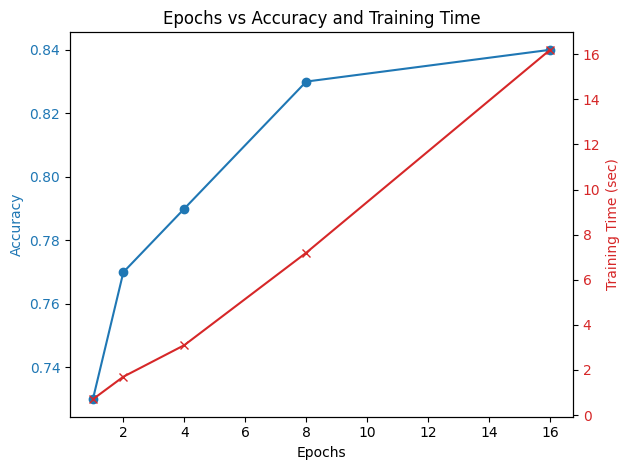

In [38]:
import matplotlib.pyplot as plt

# Data
epochs = [1, 2, 4, 8, 16]
accuracy = [0.73, 0.77, 0.79, 0.83, 0.84]
training_time = [0.7, 1.7, 3.1, 7.2, 16.2]  # in seconds

# Plot setup
fig, ax1 = plt.subplots()

# Accuracy plot
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(epochs, accuracy, marker='o', color='tab:blue', label='Accuracy')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Training time plot (second y-axis)
ax2 = ax1.twinx()
ax2.set_ylabel('Training Time (sec)', color='tab:red')
ax2.plot(epochs, training_time, marker='x', color='tab:red', label='Training Time')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Final touches
plt.title('Epochs vs Accuracy and Training Time')
fig.tight_layout()

Conclusion: We can see that the first jump is the biggest relative improvement in performance, from 1 to 2 epochs. We can see that from 8 to 16 epochs the slope shows a lower relative improvement. The training time looks to evolve linear. Therefore our hypothesis is true, but it also shows there is a tradeoff between how much time you need to train vs the extra amount of performance that is achieved.


- changing the amount of units1 and units2 to values between 16 and 1024. Use factors of 2 to easily scan the ranges: 16, 32, 64, etc.
- Hypothesis: Adding more units will improve the model, but there is a turning point where it will start overfitting.

In [86]:
model = DenseNeuralNetwork(num_classes=10, units1=128, units2=128, input_size=28*28)

settings = TrainerSettings(
    epochs=5,
    metrics= [metrics.Accuracy()],
    logdir="modellogs",
    train_steps= 50,
    valid_steps= 50,
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML],
)

trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=loss_fn,
    optimizer=optim.Adam,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=optim.lr_scheduler.ReduceLROnPlateau
)
trainer.loop()

2025-10-04 17:07:30.850 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs\20251004-170730
2025-10-04 17:07:30.853 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 50/50 [00:00<00:00, 115.29it/s]
2025-10-04 17:07:31.466 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 1.3923 test 0.8983 metric ['0.6800']
100%|██████████| 50/50 [00:00<00:00, 131.60it/s]
2025-10-04 17:07:32.016 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.7607 test 0.6682 metric ['0.7681']
100%|██████████| 50/50 [00:00<00:00, 111.74it/s]
2025-10-04 17:07:32.633 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.6686 test 0.6438 metric ['0.7700']
100%|██████████| 50/50 [00:00<00:00, 100.29it/s]
2025-10-04 17:07:33.316 | INFO     | mltrainer.trainer:report:209 - Epoch 3 train 0.5846 test 0.6428 metric ['0.7603']
100%|██████████| 50/50 [00:00<00:00, 116.83it/s]
2025-10-04 17:07

Results: 16 units/accuracy 0.66/1.14train/0.97 test, 32 units/accuracy 0.70/1.00train/0.86 test, 64 units/accuracy 0.72/0.84train/0.75 test, 128 units/accuracy 0.72/0.72train/0.71 test, 256 units/accuracy 0.76/0.70train/0.67 test, 512 units/accuracy 0.76/0.65train/0.64test, 1024 units/accuracy 0.79/0.58train/0.56test   

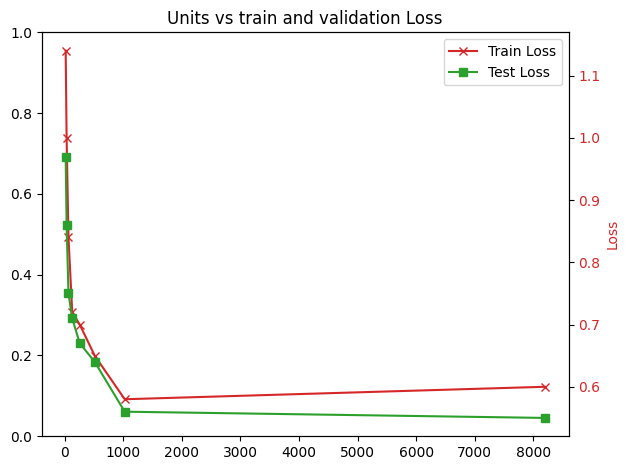

In [1]:
# Data
units = [16, 32, 64, 128, 256, 512, 1024, 8192]
# accuracy = [0.66, 0.70, 0.72, 0.72, 0.76, 0.76, 0.79, 0.80]
train = [1.14, 1.0, 0.84, 0.72, 0.70, 0.65, 0.58, 0.60]  
test = [0.97, 0.86, 0.75, 0.71, 0.67, 0.64, 0.56, 0.55]

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# ax1.set_xlabel('Units')
# ax1.set_ylabel('Accuracy', color='tab:blue')
# ax1.plot(units, accuracy, marker='o', color='tab:blue', label='Accuracy')
# ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(units, train, marker='x', color='tab:red', label='Train Loss')
ax2.plot(units, test, marker='s', color='tab:green', label='Test Loss')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.title('Units vs train and validation Loss')
fig.tight_layout()
plt.show()

Conclusion: The hypothesis is false for the overfitting at least up until 8192 units. The model consistenly performs better on the test set than the train set.

- changing the learningrate to values between 1e-2 and 1e-5
- Hypothesis: increasing the learning rate will improve the accuracy of the model

In [61]:
model = DenseNeuralNetwork(num_classes=10, units1=64, units2=64, input_size=28*28)

settings = TrainerSettings(
    epochs=2,
    metrics= [metrics.Accuracy()],
    logdir="modellogs",
    train_steps= 50,
    valid_steps= 50,
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML],
)

trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=loss_fn,
    optimizer=torch.optim.Adam(model.parameters(),lr=0.01),
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau
)
trainer.loop()

2025-10-04 16:44:54.089 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs\20251004-164454


TypeError: 'Adam' object is not callable

- change the depth of your model by adding a additional linear layer + activation function
- Hypothesis: a deeper model will perform better, but will also take longer to train

In [88]:
class DeepDenseNeuralNetwork(nn.Module):
    def __init__(self, num_classes, units1, units2, units3, units4, input_size):
        super().__init__() # moet erbij zodat alles van de nn module wordt overgenomen
        self.num_classes = num_classes
        self.units1 = units1         
        self.units2 = units2
        self.units3 = units3
        self.units4 = units4
        self.input_size = input_size
        self.flatten = nn.Flatten()

        # ik kies hier voor een simpel model met 4 hidden layers
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(self.input_size, self.units1),
            nn.ReLU(),
            nn.Linear(self.units1, self.units2),
            nn.ReLU(),
            nn.Linear(self.units2, self.units3),
            nn.ReLU(),
            nn.Linear(self.units3, self.units4),
            nn.ReLU(),
            nn.Linear(self.units4, self.num_classes)
        )
    
    # forward maken we hier zodat we de volgorde van de bewerkingen kunnen bepalen, eerst flattenen zodat we de input in 1D krijgen en dus kunnen doorgeven aan de linear layers
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
number_of_units = 128
deep_model = DeepDenseNeuralNetwork(num_classes=10, units1=number_of_units, units2=number_of_units, units3=number_of_units, units4=number_of_units, input_size=28*28)

settings = TrainerSettings(
    epochs=5,
    metrics= [metrics.Accuracy()],
    logdir="modellogs",
    train_steps= 50,
    valid_steps= 50,
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML],
)

trainer = Trainer(
    model=deep_model,
    settings=settings,
    loss_fn=loss_fn,
    optimizer=torch.optim.Adam,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau
)
trainer.loop()

2025-10-04 17:31:18.615 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs\20251004-173118
2025-10-04 17:31:18.619 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 400/400 [00:04<00:00, 80.03it/s]
2025-10-04 17:31:25.271 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 0.7481 test 0.5534 metric ['0.8007']
100%|██████████| 400/400 [00:05<00:00, 72.71it/s]
2025-10-04 17:31:32.439 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.4790 test 0.4985 metric ['0.8191']
100%|██████████| 400/400 [00:05<00:00, 73.81it/s]
2025-10-04 17:31:39.406 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.4256 test 0.4302 metric ['0.8415']
100%|██████████| 400/400 [00:05<00:00, 72.07it/s]
2025-10-04 17:31:47.389 | INFO     | mltrainer.trainer:report:209 - Epoch 3 train 0.3970 test 0.4167 metric ['0.8507']
100%|██████████| 400/400 [00:06<00:00, 57.44it/s]
2025-10-04 

Results: Neural network with 2 layers performs 0.79 and takes 3s and Neural network with 4 layers performs 0.78 and takes 3.9s

Conclusion: A deep network does not always perform better with more layers

- changing the batchsize to values between 4 and 128. Again, use factors of two for convenience.
- Hypothesis: When the step size is large, this means the model has more changes to update its weights and therefore train faster.

In [98]:
model = DenseNeuralNetwork(num_classes=10, units1=64, units2=64, input_size=28*28)

settings = TrainerSettings(
    epochs=2,
    metrics= [metrics.Accuracy()],
    logdir="modellogs",
    train_steps= len(train)//batchsize,
    valid_steps= len(valid)//batchsize,
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML],
)

trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=loss_fn,
    optimizer=torch.optim.Adam,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau
)
trainer.loop()

2025-10-04 17:58:07.976 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs\20251004-175807
2025-10-04 17:58:07.976 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 14/14 [00:00<00:00, 95.98it/s]
2025-10-04 17:58:08.152 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 2.1694 test 1.9410 metric ['0.5156']
100%|██████████| 14/14 [00:00<00:00, 146.98it/s]
2025-10-04 17:58:08.265 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 1.6675 test 1.3637 metric ['0.6016']
100%|██████████| 2/2 [00:00<00:00,  7.17it/s]


Results: steps 4/accuracy 0.39/time 0.1s, steps 128/accuracy 0.77/time 2.7s, steps 512/accuracy 0.82/time 13.8s

Conclusion: It is true that the higher the steps the higher the performance because it sees more data, but also the higher the training time. It can be smart to keep the trainsteps equal to the length of the full dataset / nr of batches so that you won't train on more than 1x your dataset. Otherwise the setting epoch = 1 will be more than the actual 1.

- changing the optimizer from SGD to one of the other available algoritms
- Hypothesis: The model will perform worse because randomly choosing the gradient is a less smart approach than the Adam approach

In [104]:
model = DenseNeuralNetwork(num_classes=10, units1=64, units2=64, input_size=28*28)

settings = TrainerSettings(
    epochs=2,
    metrics= [metrics.Accuracy()],
    logdir="modellogs",
    train_steps= len(train)//batchsize,
    valid_steps= len(valid)//batchsize,
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML],
)

trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=loss_fn,
    optimizer=torch.optim.SGD,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau
)
trainer.loop()

NameError: name 'params' is not defined

Results: SGD gives accuracy 0.12/Adadelta gives acc 0.17/Adafactor gives acc 0.09

Conclusion: Choosing three other optimizers give very bad results. Mostly because the learning rate in adam is set adaptive - but with the others it should be set manually.